# Step 1: Problem Formulation as MDP

## 1) Time and System Setup

We consider hourly steps $t = 1,\ldots,T$.

- Battery capacity: $E_{\max} = 400$ MWh  
- Charge/discharge power: $P_{\max} = 100$ MW  
- SOC dynamics:

$E_{t+1} = E_t + P_{\max}$  (charge)  
$E_{t+1} = E_t - P_{\max}$  (discharge)  
$E_{t+1} = E_t$             (idle)

with $0 \le E_t \le E_{\max}$.

## 2) State Space

State components:
- SOC level $i \in \{0,\ldots,4\}$
- Previous-hour price bin $k \in \{1,\ldots,5\}$

State:
$s_t = (i_t, k_{t-1})$

State space:
$S = \{0,\ldots,4\} \times \{1,\ldots,5\}$

## 3) Action Space

Actions:
- $a = 1$: charge  
- $a = 0$: idle  
- $a = -1$: discharge  

Feasibility:
- if $i_t = 0$: no $a = -1$  
- if $i_t = 4$: no $a = 1$  

Thus $A(s)$ is the set of feasible actions.

## 4) Reward Function

Instantaneous reward:

$r_t = \lambda_t \, P_{\max} \, (-a_t)$

Charging gives negative reward, discharging positive.

In the MDP we use price bins.  
Let $\bar{\lambda}(k_t)$ be the representative price of bin $k_t$.

Reward:

$R(s_t,a_t,s_{t+1}) = \bar{\lambda}(k_t)\,P_{\max}\,(-a_t)$

## 5) Transition Probabilities

### SOC transition (deterministic)

$i_{t+1} = i_t + a_t$

$P_{\text{SOC}}(i'|i,a) = 1$ if $i' = i + a$, else $0$.

### Price transition (Markov chain)

$P_{\text{price}}(k'|k) = \frac{N_{k,k'}}{\sum_j N_{k,j}}$

### Full transition

$P((i',k')|(i,k),a) = P_{\text{SOC}}(i'|i,a) \, P_{\text{price}}(k'|k)$

## 6) Discount Factor and Objective

Discount factor:

$\gamma \in (0,1]$ (e.g. $\gamma = 0.99$)

Objective under policy $\pi$:

$J(\pi) = \mathbb{E}_\pi \left[\sum_{t=1}^T \gamma^{t-1} r_t\right]$

## 7) Final MDP Definition

The MDP is  
$M = (S, A, P, R, \gamma)$.

State space:  
$S = \{0,\ldots,4\} \times \{1,\ldots,5\}$

Action space:  
$A(s) \subseteq \{-1,0,1\}$

Transition model:  
$P = P_{\text{SOC}} \cdot P_{\text{price}}$

Reward:  
$R((i,k),a,(i',k')) = \bar{\lambda}(k')\,P_{\max}\,(-a)$

Discount factor:  
$\gamma \in (0,1]$

In [19]:
import pandas as pd
import numpy as np

df_price = pd.read_excel("Price.xlsx")
df_price = df_price[df_price["PriceArea"]=="DK2"].drop(
    columns=["HourUTC"]).rename(
        columns={"HourDK":"Hour"}).reset_index(drop=True)

df_train = df_price.iloc[:int(round(0.8*len(df_price),0))].copy()
df_test  = df_price.iloc[int(round(0.8*len(df_price),0)):].copy()
df_train.head()

,Hour,PriceArea,PriceDKK,PriceEUR
0,2021-01-01 00:00:00,DK2,378.519989,50.869999
1,2021-01-01 01:00:00,DK2,358.579987,48.189999
2,2021-01-01 02:00:00,DK2,332.459991,44.680000
3,2021-01-01 03:00:00,DK2,319.369995,42.919998
4,2021-01-01 04:00:00,DK2,300.540009,40.389999


In [ ]:
import numpy as np

num_bins = 5

# Extract training prices
train_prices = df_train["PriceDKK"].values
test_prices  = df_test["PriceDKK"].values

# Bin edges based on train prices 
bin_edges = np.quantile(train_prices, np.linspace(0, 1, num_bins + 1))
bin_edges[0] -= 1e-6  # ensure min value captured

# Assign bins 
df_train["price_bin"] = np.clip(np.digitize(train_prices, bin_edges), 1, num_bins)
df_test["price_bin"]  = np.clip(np.digitize(test_prices,  bin_edges), 1, num_bins)

# Price transition matrix 
P_price = np.zeros((num_bins, num_bins))
bins_train = df_train["price_bin"].values

for t in range(1, len(bins_train)):
    k_prev = bins_train[t-1] - 1  # convert 1..5 → 0..4
    k_now  = bins_train[t]   - 1
    P_price[k_prev, k_now] += 1

# Avoid division by zero 
row_sums = P_price.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1  
P_price = P_price / row_sums

# Representative price per bin
lambda_bar = np.zeros(num_bins)

for k in range(num_bins):
    members = train_prices[df_train["price_bin"] == (k + 1)]
    lambda_bar[k] = members.mean() if len(members) > 0 else 0.0

# SOC levels & action set
SOC_levels = np.arange(5)        # [0,1,2,3,4]
actions = np.array([-1, 0, 1])   # discharge, idle, charge

### Step 2: Implementation of Value Iteration or Policy Iteration Algorithms

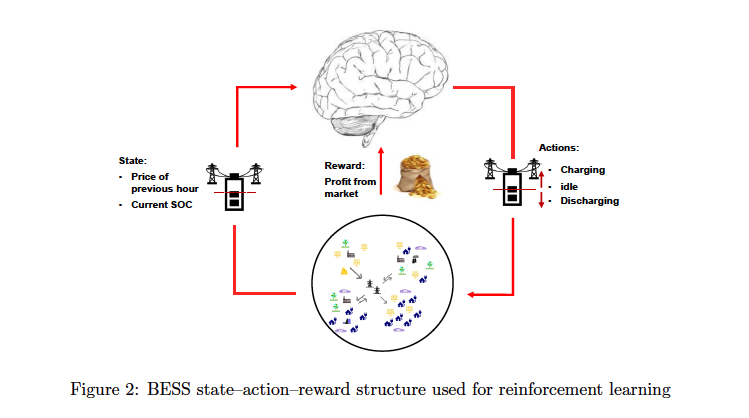

#### Value iteration

In [ ]:
## compact state index 
num_soc = len(SOC_levels)      # 5
num_price_states = P_price.shape[0]  # should be 5

states = []
state_to_idx = {}

for i in range(num_soc):
    for k_prev in range(num_price_states):  # 0..4
        s_idx = len(states)
        states.append((i, k_prev))
        state_to_idx[(i, k_prev)] = s_idx

num_states = len(states)
num_actions = len(actions)

print("Number of states:", num_states)
print("Example states:", states[:5])

Number of states: 25
Example states: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]


In [ ]:
## Feasible actions per SOC level
def feasible_actions_for_soc(i, actions, max_soc_index):
    feas = []
    for a in actions:
        if i == 0 and a == -1:
            continue
        if i == max_soc_index and a == 1:
            continue
        feas.append(a)
    return feas

max_soc_index = SOC_levels[-1]  # 4

# Build feasible action list per state
feasible_actions = []
for (i, k_prev) in states:
    feas = feasible_actions_for_soc(i, actions, max_soc_index)
    feasible_actions.append(feas)

# Quick check for a few states
for idx in [0, 4, 20]:
    print("State", idx, "=", states[idx], "feasible actions:", feasible_actions[idx])

State 0 = (0, 0) feasible actions: [np.int64(0), np.int64(1)]
State 4 = (0, 4) feasible actions: [np.int64(0), np.int64(1)]
State 20 = (4, 0) feasible actions: [np.int64(-1), np.int64(0)]


In [25]:
## Build transition probabilities P[s, a, s’]

P = np.zeros((num_states, num_actions, num_states))

for s_idx, (i, k_prev) in enumerate(states):
    for a_idx, a in enumerate(actions):
        # skip infeasible actions
        if a not in feasible_actions[s_idx]:
            continue
        
        i_next = i + a  # deterministic SOC update
        # safety: skip if out of range (shouldn't happen if feasible_actions is correct)
        if i_next < 0 or i_next > max_soc_index:
            continue
        
        # price transition: k_prev -> k_next
        for k_next in range(num_price_states):
            prob_price = P_price[k_prev, k_next]
            if prob_price == 0:
                continue
            s_next = state_to_idx[(i_next, k_next)]
            P[s_idx, a_idx, s_next] += prob_price

# Quick sanity check: rows for feasible actions should sum to ~1
row_sums = P.sum(axis=2)  # shape: (num_states, num_actions)
print("Row sums (first few states):")
print(row_sums[:5])

Row sums (first few states):
[[0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]]


In [26]:
## Build reward matrix R[s, a]
P_max = 100.0  # MW

R = np.zeros((num_states, num_actions))

for s_idx, (i, k_prev) in enumerate(states):
    # expected next price given current price state
    expected_price = np.dot(P_price[k_prev, :], lambda_bar)
    
    for a_idx, a in enumerate(actions):
        if a not in feasible_actions[s_idx]:
            # we can either set reward very negative or ignore later;
            # here we just leave it as 0 and skip it in value iteration
            continue
        
        R[s_idx, a_idx] = expected_price * P_max * (-a)

# Quick check
print("Sample rewards:", R[0])

Sample rewards: [     0.              0.         -23944.83361651]


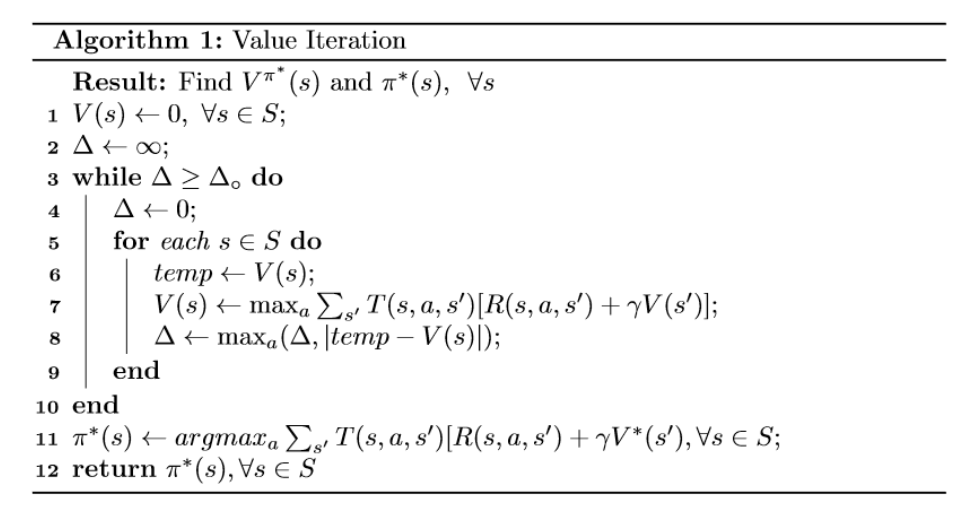

In [51]:
## Value iteration

gamma = 0.99
max_iter = 10000
tol = 1e-6

V = np.zeros(num_states)
deltas = []
snapshots = {}

for it in range(max_iter):
    V_old = V.copy()
    
    for s_idx in range(num_states):
        q_values = []
        
        for a_idx, a in enumerate(actions):
            if a not in feasible_actions[s_idx]:
                continue
            
            q_sa = R[s_idx, a_idx] + gamma * np.dot(P[s_idx, a_idx, :], V_old)
            q_values.append(q_sa)
        
        V[s_idx] = max(q_values) if q_values else 0.0
    
    delta = np.max(np.abs(V - V_old))
    deltas.append(delta)

    if it % 500 == 0:
        snapshots[it] = V.copy()
    
    if delta < tol:
        print(f"Converged after {it+1} iterations, delta={delta:.2e}")
        break
else:
    print("Warning: value iteration did not fully converge")

Converged after 2224 iterations, delta=9.97e-07


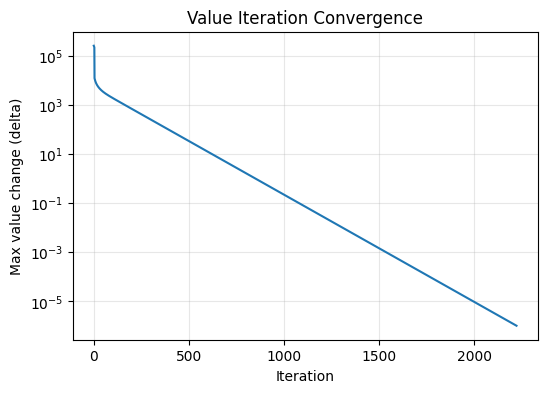

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(deltas)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Max value change (delta)")
plt.title("Value Iteration Convergence")
plt.grid(True, alpha=0.3)
plt.show()

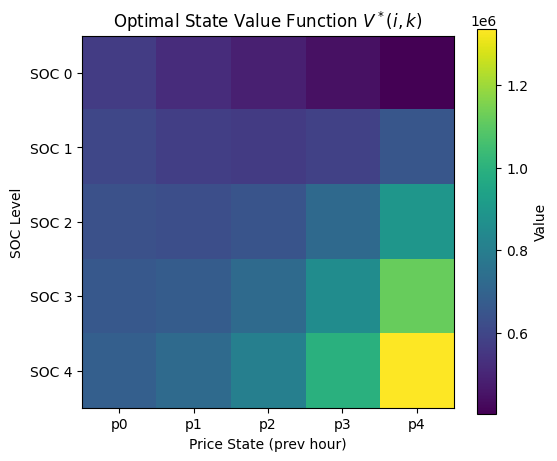

In [53]:
V_matrix = np.zeros((num_soc, num_price_states))

for i in range(num_soc):
    for k_prev in range(num_price_states):
        s_idx = state_to_idx[(i, k_prev)]
        V_matrix[i, k_prev] = V[s_idx]

plt.figure(figsize=(6,5))
plt.imshow(V_matrix, cmap="viridis")
plt.colorbar(label="Value")
plt.xticks(range(num_price_states), [f"p{k}" for k in range(num_price_states)])
plt.yticks(range(num_soc), [f"SOC {i}" for i in range(num_soc)])
plt.title("Optimal State Value Function $V^*(i, k)$")
plt.xlabel("Price State (prev hour)")
plt.ylabel("SOC Level")
plt.show()

In [33]:
## Extract the optimal policy π* (greedy w.r.t. V)

# policy indices: for each state, store index into `actions`
policy_idx = np.zeros(num_states, dtype=int)

for s_idx in range(num_states):
    best_q = -np.inf
    best_a_idx = 0  # default
    
    for a_idx, a in enumerate(actions):
        if a not in feasible_actions[s_idx]:
            continue
        
        q_sa = R[s_idx, a_idx] + gamma * np.dot(P[s_idx, a_idx, :], V)
        if q_sa > best_q:
            best_q = q_sa
            best_a_idx = a_idx
    
    policy_idx[s_idx] = best_a_idx

# Optional: map to actual action values
policy_actions = actions[policy_idx]

policy_matrix = np.zeros((num_soc, num_price_states), dtype=int)

for i in range(num_soc):
    for k_prev in range(num_price_states):
        s_idx = state_to_idx[(i, k_prev)]
        policy_matrix[i, k_prev] = policy_actions[s_idx]

df_policy = pd.DataFrame(
    policy_matrix,
    index=[f"SOC {i}" for i in range(num_soc)],
    columns=[f"PriceState {k}" for k in range(num_price_states)]
)

df_policy

,PriceState 0,PriceState 1,PriceState 2,PriceState 3,PriceState 4
SOC 0,1,1,1,1,0
SOC 1,1,1,1,1,-1
SOC 2,1,1,1,1,-1
SOC 3,1,1,1,0,-1
SOC 4,0,0,0,-1,-1


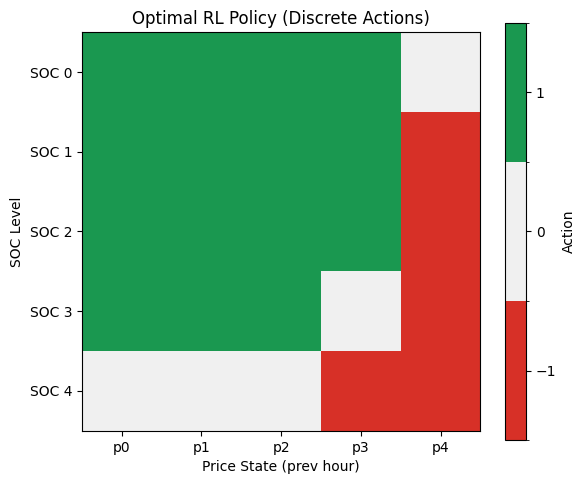

In [38]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Create discrete color map for 3 actions
cmap = ListedColormap(["#d73027", "#f0f0f0", "#1a9850"])
bounds = [-1.5, -0.5, 0.5, 1.5]  # boundaries for -1, 0, +1
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(6,5))
plt.imshow(policy_matrix, cmap=cmap, norm=norm)

plt.colorbar(ticks=[-1,0,1], label="Action")
plt.xticks(range(num_price_states), [f"p{k}" for k in range(num_price_states)])
plt.yticks(range(num_soc), [f"SOC {i}" for i in range(num_soc)])
plt.title("Optimal RL Policy (Discrete Actions)")
plt.xlabel("Price State (prev hour)")
plt.ylabel("SOC Level")

plt.tight_layout()
plt.show()

### Step 3: Evaluation of the Obtained Policy

In [56]:
# --- Simulation over test set using optimal policy ---

max_soc_index = SOC_levels[-1]

# Initial conditions
soc_idx = 0  # start empty (SOC index)
prev_price_bin_idx = df_test["price_bin"].iloc[0] - 1  # use first bin as "previous"

profits = []
soc_history = []
action_history = []

for t in range(len(df_test)):
    price = df_test["PriceDKK"].iloc[t]
    price_bin_idx = df_test["price_bin"].iloc[t] - 1  # 0..4

    # Current state (SOC, previous price bin)
    s_idx = state_to_idx[(soc_idx, prev_price_bin_idx)]
    action = policy_actions[s_idx]  # -1, 0, 1

    # Enforce feasibility (safety)
    if soc_idx == 0 and action == -1:
        action = 0
    if soc_idx == max_soc_index and action == 1:
        action = 0

    # Profit for this hour
    profit_t = price * P_max * (-action)

    # Log
    profits.append(profit_t)
    soc_history.append(soc_idx)
    action_history.append(action)

    # Update SOC
    soc_idx = soc_idx + action
    soc_idx = max(0, min(max_soc_index, soc_idx))

    # Update previous price bin for next step
    prev_price_bin_idx = price_bin_idx

total_profit_rl = np.sum(profits)
print("Total RL profit on test set:", total_profit_rl)

Total RL profit on test set: 5486997.9396


In [58]:
# add to dataframe for analysis
df_test_eval = df_test.copy()
df_test_eval["SOC_idx"] = soc_history
df_test_eval["Action"] = action_history
df_test_eval["Profit"] = profits

df_test_eval.head(10)

,Hour,PriceArea,PriceDKK,PriceEUR,price_bin,SOC_idx,Action,Profit
19026,2023-03-04 18:00:00,DK2,1128.640015,151.660004,4,0,1,-112864.0015
19027,2023-03-04 19:00:00,DK2,1070.069946,143.789993,4,1,1,-107006.9946
19028,2023-03-04 20:00:00,DK2,915.280029,122.989998,3,2,1,-91528.0029
19029,2023-03-04 21:00:00,DK2,854.919983,114.879997,3,3,1,-85491.9983
19030,2023-03-04 22:00:00,DK2,837.440002,112.529999,3,4,0,0.0000
19031,2023-03-04 23:00:00,DK2,810.940002,108.970001,3,4,0,0.0000
19032,2023-03-05 00:00:00,DK2,800.349976,107.529999,3,4,0,0.0000
19033,2023-03-05 01:00:00,DK2,790.820007,106.250000,3,4,0,0.0000
19034,2023-03-05 02:00:00,DK2,785.609985,105.550003,3,4,0,0.0000
19035,2023-03-05 03:00:00,DK2,795.210022,106.839996,3,4,0,0.0000


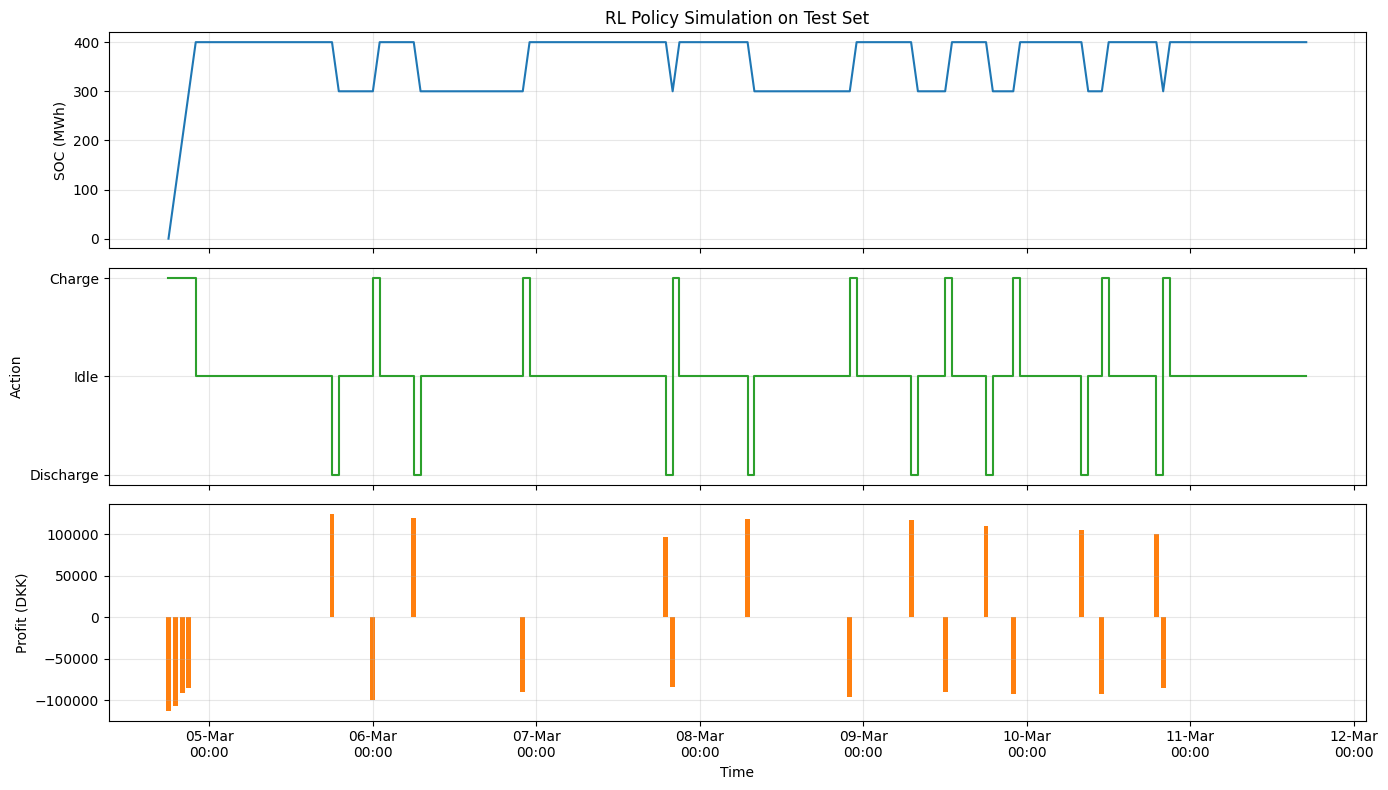

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Select a time window (example: first 168 hours = 1 week)
# You can change this to a datetime slice if preferred:
# subset = df_test_eval.loc["2023-01-01":"2023-01-07"]
subset = df_test_eval.iloc[:168]   # first week

# Convert time column to datetime if needed
if not np.issubdtype(subset["Hour"].dtype, np.datetime64):
    subset["Hour"] = pd.to_datetime(subset["Hour"])

time = subset["Hour"]
soc = subset["SOC_idx"] * 100       # convert SOC index → MWh
actions = subset["Action"]
profits = subset["Profit"]

# Plot
fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

# --- 1. SOC ---
axes[0].plot(time, soc, color="tab:blue", linewidth=1.5)
axes[0].set_ylabel("SOC (MWh)")
axes[0].set_title("RL Policy Simulation on Test Set")
axes[0].grid(True, alpha=0.3)

# --- 2. Actions ---
axes[1].step(time, actions, where="post", color="tab:green")
axes[1].set_ylabel("Action")
axes[1].set_yticks([-1, 0, 1])
axes[1].set_yticklabels(["Discharge", "Idle", "Charge"])
axes[1].grid(True, alpha=0.3)

# --- 3. Hourly Profit ---
axes[2].bar(time, profits, color="tab:orange", width=0.03)
axes[2].set_ylabel("Profit (DKK)")
axes[2].grid(True, alpha=0.3)

# Format x-axis nicely with date/time
axes[2].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[2].xaxis.set_major_formatter(mdates.DateFormatter("%d-%b\n%H:%M"))

plt.xlabel("Time")
plt.tight_layout()
plt.show()

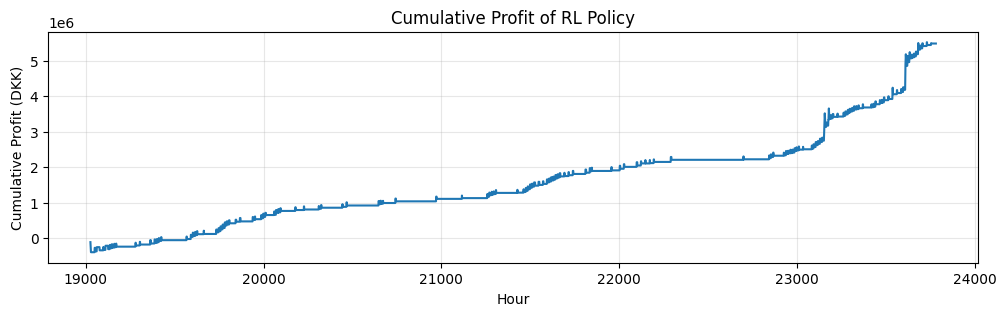

In [65]:
plt.figure(figsize=(12,3))
plt.plot(np.cumsum(df_test_eval["Profit"]))
plt.title("Cumulative Profit of RL Policy")
plt.xlabel("Hour")
plt.ylabel("Cumulative Profit (DKK)")
plt.grid(True, alpha=0.3)
plt.show()

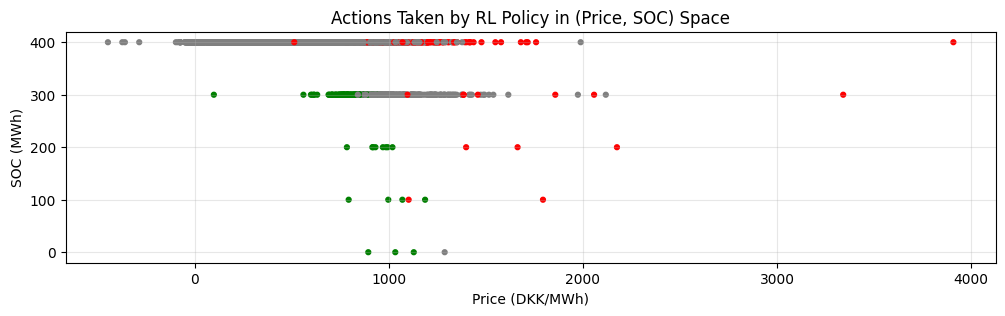

In [66]:
plt.figure(figsize=(12,3))
plt.scatter(df_test_eval["PriceDKK"], df_test_eval["SOC_idx"]*100,
            c=df_test_eval["Action"], cmap=ListedColormap(["red","grey","green"]),
            s=12)
plt.xlabel("Price (DKK/MWh)")
plt.ylabel("SOC (MWh)")
plt.title("Actions Taken by RL Policy in (Price, SOC) Space")
plt.grid(True, alpha=0.3)
plt.show()

### Step 4: Comparison of Models 1 and 2